In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
# from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid
# from rebin_fk_data import rebin_fk
from read_data_with_fk import read_LHEF_data, get_fk_table

In [2]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 10

#HYPERPARAMETERS
preproc = 1

fit_level = 2

max_counter = 100
max_Nepochs = 3500

In [3]:
data, data_min, data_max, xvals_per_obs, binwidths, xlabels, events_per_obs = (
        read_LHEF_data()
    )

print(data)

data= data*3000/150
data_min= data_min*3000/150
data_max= data_max*3000/150
events_per_obs= events_per_obs*3000/150
print(len(data))
x_alphas, fk_tables = get_fk_table()


[0.         0.         0.         0.094313   0.9533138  2.51132204
 3.93680016 5.23786777 6.40649562 7.07745875 7.57275389 7.8927729
 7.75097967 7.80799014 7.82436612 7.83251652 7.48683239 7.59532843
 7.35748211 7.42732438 7.21175136 7.24927934 7.10258711 6.72873534
 6.77501321 6.88061138 6.59936464 6.25423221 6.2874791  6.10783923
 5.84237147 5.5604157  5.36252868 5.05682925 5.16613541 5.01160697
 4.69878161 4.59145432 4.48264121 4.06085679 4.04650594 3.73613606
 3.49654717 3.57659873 3.33974943 2.95227988 3.10489921 2.83401258
 2.77078443 2.62533694 2.61220838 2.48143489 2.23667688 2.30679934
 2.13639288 2.03958155 1.81928589 1.82465507 1.695446   1.77255058
 1.47716924 1.54680841 1.55989406 1.38110946 1.27994838 1.24281524
 1.22894702 1.15565802 1.04646215 0.96802026 1.00402038 0.89231183
 0.83667821 0.87928394 0.71099294 0.72771074 0.73217387 0.74030913
 0.69149751 0.64268594 0.58031556 0.59140725 0.50237153 0.47457795
 0.51742266 0.46194144 0.4143409  0.40363358 0.41897132 0.29945

In [4]:

#Get errors
sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max)    

#Generate MC replicas of data
sig_stat = np.sqrt(data)
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat)
# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),12)

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [5]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_77794/1710910134.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


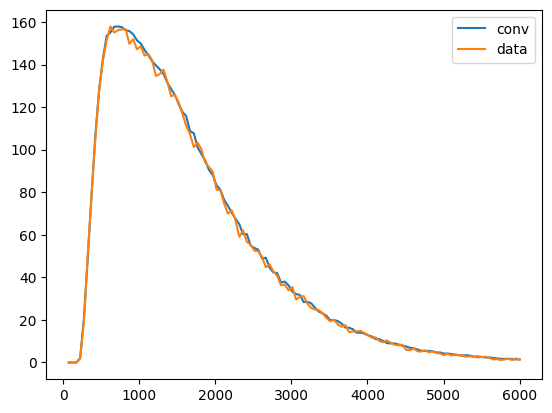

In [6]:
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_tables,faser_pdf) * binwidths * 3000/150
plt.plot(xvals_per_obs,conv,label='conv')
plt.plot(xvals_per_obs,data,label='data')
plt.legend()

In [7]:
def aggregate_entries_with_indices(threshold=20):
    rebin_data,rebin_data_max,rebin_data_min,rebin_fk_table,rebin_xvals_per_obs,rebin_events_per_obs = [],[],[],[],[],[],
    current_sum = 0
    start_idx = 0
    
    for i, value in enumerate(data):
        current_sum += value
        
        if current_sum >= threshold:
            rebin_data.append(sum(data[start_idx:i+1]))  # Sum based on indices
            rebin_data_max.append(sum(data_max[start_idx:i+1]))
            rebin_data_min.append(sum(data_min[start_idx:i+1]))
            rebin_events_per_obs.append(sum(events_per_obs[start_idx:i+1]))
            rebin_xvals_per_obs.append(xvals_per_obs[start_idx])

            summed_column = torch.sum(fk_tables[start_idx:i +1, :], axis=0)
            summed_column = summed_column.unsqueeze(0)

            rebin_fk_table.append(summed_column)
            current_sum = 0
            start_idx = i + 1
    
    # If there are remaining events that haven't been added, keep them as the last entry
    if current_sum > 0:
        rebin_data.append(sum(data[start_idx:]))
        rebin_data_max.append(sum(data_max[start_idx:]))
        rebin_data_min.append(sum(data_min[start_idx:]))
        rebin_events_per_obs.append(sum(events_per_obs[start_idx:]))
        summed_column = torch.sum(fk_tables[start_idx:, :], axis=0)
        summed_column = summed_column.unsqueeze(0)
    
        rebin_fk_table.append(summed_column)
        rebin_xvals_per_obs.append(xvals_per_obs[start_idx])
    return rebin_data,rebin_data_max,rebin_data_min,rebin_fk_table, rebin_events_per_obs, rebin_xvals_per_obs

data,data_max,data_min,fk_table, events_per_obs, xvals_per_obs = aggregate_entries_with_indices(20)

fk_table = torch.cat(fk_table, dim=0)    
data = np.array(data)
data_min = np.array(data_min)
data_max = np.array(data_max)

In [8]:
print(len(data))

79


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_77794/3761571445.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


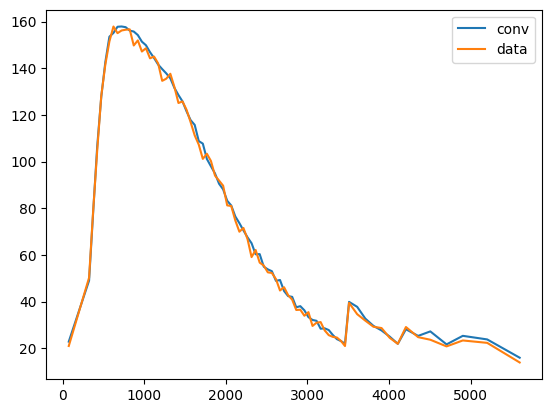

In [9]:
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_table,faser_pdf) * binwidths * 3000/150
plt.plot(xvals_per_obs,conv,label='conv')
plt.plot(xvals_per_obs,data,label='data')
plt.legend()

In [10]:

#Get errors
sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max)    
#Generate MC replicas of data
sig_stat = np.sqrt(data)
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat)
# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals,14)

#2t/m8

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [11]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

[ 20.95253583  50.22644087  78.73600319 104.75735541 128.12991244
 141.54917499 151.45507776 157.85545797 155.0195935  156.15980275
 156.48732238 156.65033034 149.73664784 151.90656868 147.14964211
 148.54648758 144.23502713 144.98558672 142.0517422  134.57470682
 135.5002642  137.61222755 131.9872928  125.08464413 125.74958197
 122.15678457 116.84742941 111.20831399 107.25057355 101.13658505
 103.32270811 100.23213934  93.97563215  91.8290865   89.65282418
  81.21713589  80.9301188   74.72272113  69.93094338  71.53197452
  66.79498851  59.04559769  62.09798422  56.68025152  55.41568857
  52.50673888  52.24416751  49.62869788  44.73353769  46.13598671
  42.72785764  40.79163099  36.38571775  36.49310144  33.9089199
  35.45101165  29.54338471  30.93616817  31.19788114  27.62218917
  25.59896752  24.85630489  24.57894041  23.11316037  20.92924309
  39.44081294  34.57980087  31.80553765  29.19769212  28.63613274
  24.46002994  21.87557554  29.078841    24.73891626  23.63229118
  20.775234

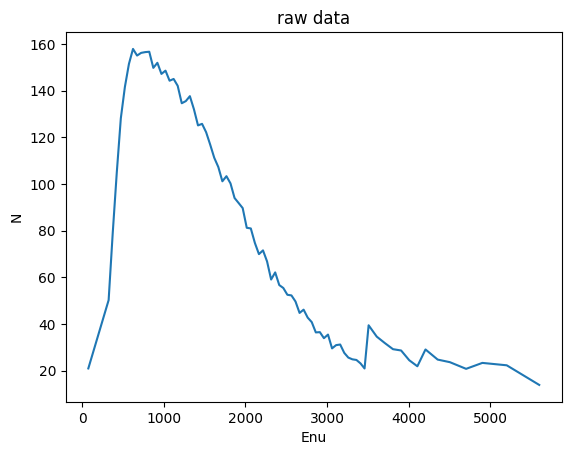

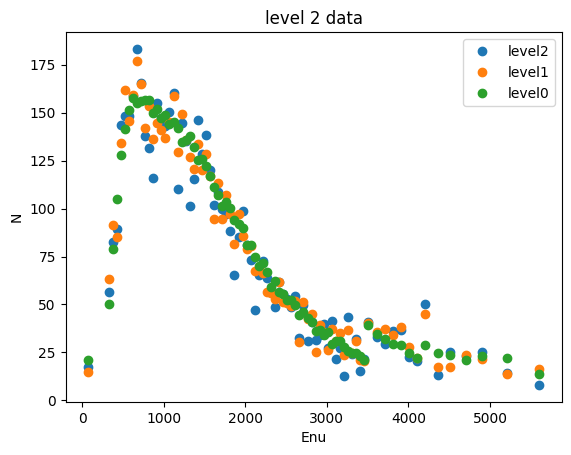

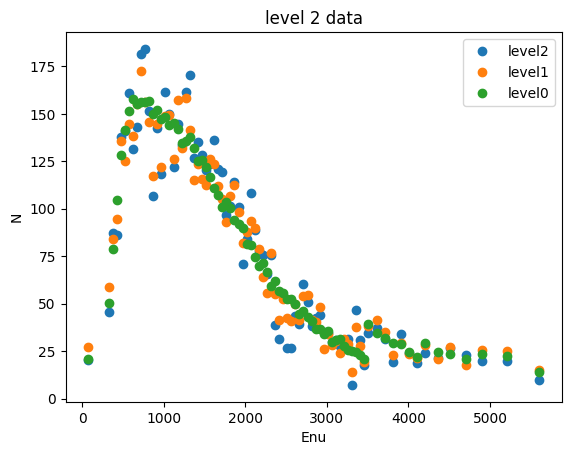

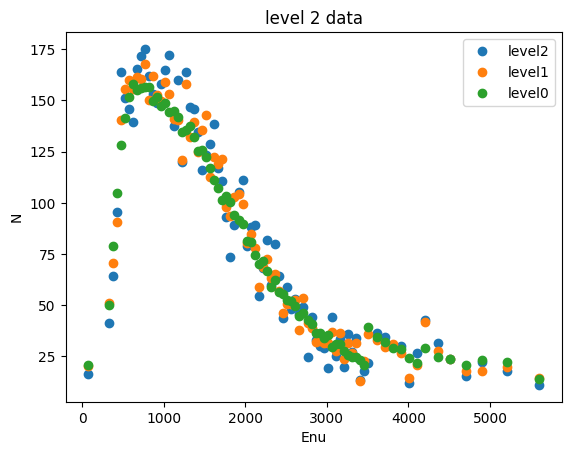

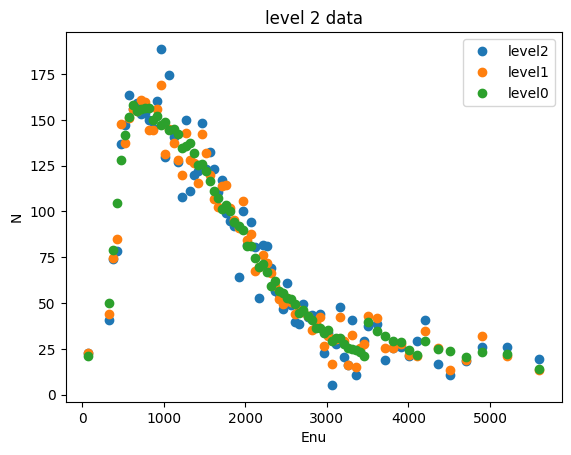

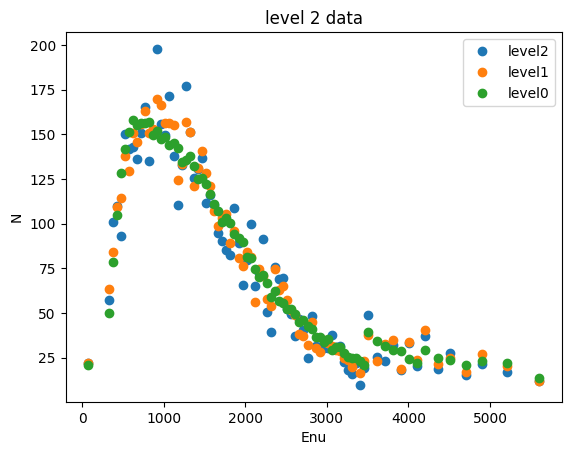

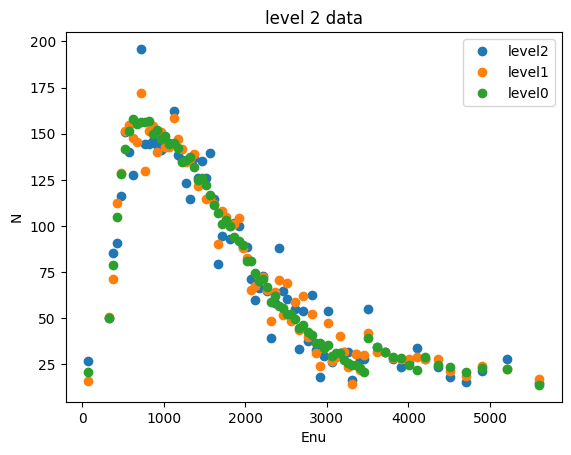

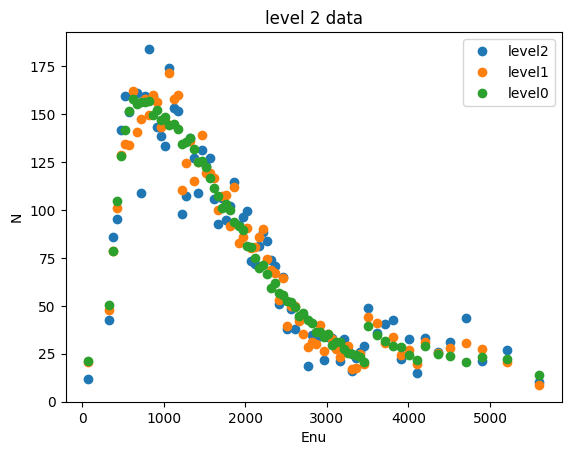

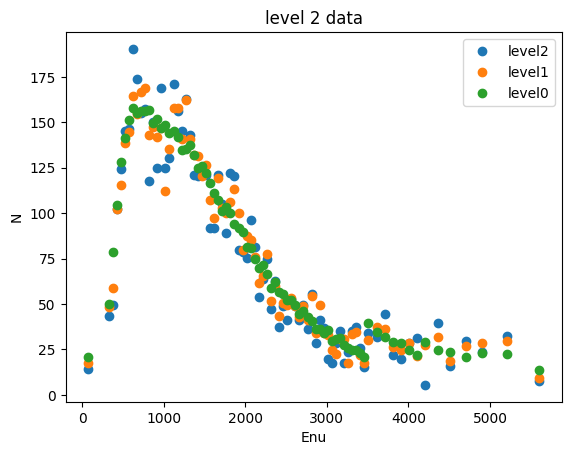

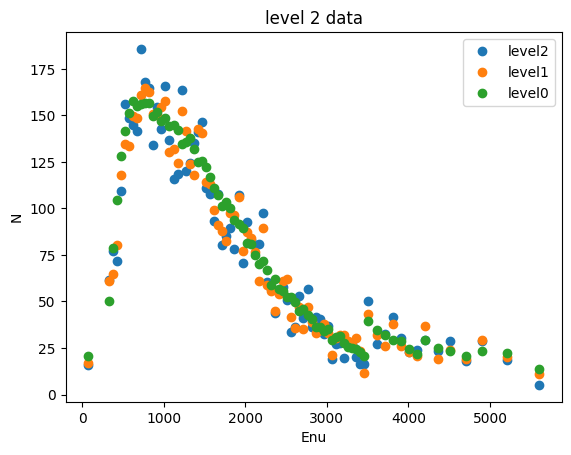

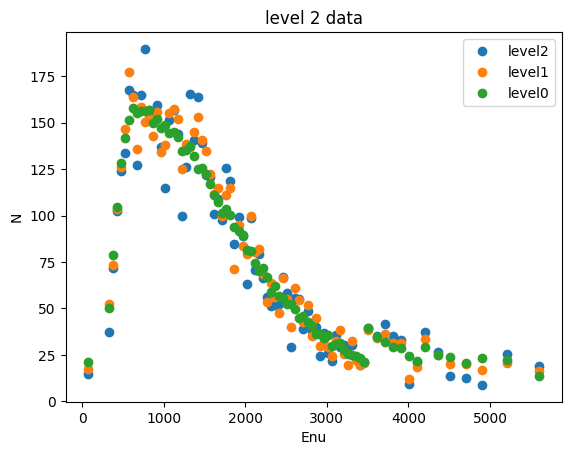

In [12]:
print(data)
print(level1)
print(level2)
plt.plot(xvals_per_obs,data)
plt.xlabel(xlabels)
plt.ylabel('N')
plt.title("raw data")
plt.show()

for i in range(REPLICAS):
    plt.plot(
        xvals_per_obs, level2[i], 'o',label="level2"
    )
    plt.plot(
        xvals_per_obs, level1[i], 'o',label="level1"
    )
    plt.plot(xvals_per_obs, data,'o',label="level0")
    plt.xlabel(xlabels)
    plt.legend()
    plt.ylabel("N")
    plt.title("level 2 data")
    plt.show()


In [13]:
import torch.nn as nn
import torch.nn.init as init
l1 = 20
l2 = 30
l3 = 20

class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.leakyrelu = torch.nn.LeakyReLU(.1)
        # self.leakyrelu = torch.nn.ReLU()
        self.tanh = torch.nn.Softplus()
        self.relu = torch.nn.Softplus()
        for layer in [self.linear, self.hidden, self.hidden2, self.hidden3]:

            init.uniform_(layer.weight, a=-10, b=10)

    

    def forward(self, y):
        y = self.linear(y)
        y = self.tanh(y)
        y = self.hidden(y)
        y = self.tanh(y)
        y = self.hidden2(y)
        y = self.tanh(y)
        y = self.hidden3(y)
        y = self.tanh(y)
        # y = torch.nn.functional.softplus(y)
    
        return y
    
    # def _initialize_weights(self):
        
    #           # Set weights in range [-0.1, 0.1]
    #         init.zeros_(layer.bias)  # Initialize biases to 0

In [14]:
import torch.nn as nn

if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()

            # self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            # self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            # self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

            self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))
            self.register_buffer("beta", torch.tensor(beta, dtype=torch.float32))
            self.register_buffer("gamma", torch.tensor(gamma, dtype=torch.float32))

        def forward(self, x):
            # alpha = (1 - 0.2)/2 *torch.tanh(self.alpha) + (1 + 0.2)/2
            # beta = (1.9 - 0.1)/2 *torch.tanh(self.alpha) + (1.9 + 0.1)/2
            # beta = torch.nn.functional.softmax(self.beta)
            # alpha = 1 - torch.nn.functional.softplus(self.alpha)
            # return self.gamma * (1 - x) ** self.beta * x**(1-self.alpha) 
            return (1 - x)* x
            # return  self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            f_preproc = self.preprocessing(x)
            f_NN = self.mlp(x)
            f_nu = f_preproc * f_NN
            return f_NN 
            # return f_NN - self.mlp(torch.tensor([1.], dtype=torch.float32).view(-1,1)) 
        
        def neuralnet(self, x):
            f_NN = self.mlp(x)
            return f_NN
        
        def preproc(self, x):
            f_preproc = self.preprocessing(x)
            return f_preproc
        


In [15]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix,small_x_point_mu, small_x_point_mub,model):
        loss = raw_loss_fct(pred,
    data,
    cov_matrix,small_x_point_mu,small_x_point_mub,model)
        return loss

In [16]:
#Define variables for fit
# x_alpha_more_bins = np.logspace(-5,0,250)
# x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
lowx = -10
n=500
x_vals = generate_grid(lowx,n)
x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
neutrino_pdfs_mu,neutrino_pdfs_mub,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys, preproc_pdfs, nn_pdfs  = [],[],[],[],[],[],[],[],[]
# x_alphas = x_alphas.clone().detach().requires_grad_(True)

faser_pdf_test,_ = read_pdf('faserv',x_alphas.detach().numpy().flatten(),12)
faser_pdf_test = torch.tensor(faser_pdf_test, dtype=torch.float32).view(-1,1)

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [17]:
lr = 0.01

def perform_fit(pred,REPLICAS):
    if preproc == 1:
            alpha,beta,gamma = 1,1,10
            model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)
    for i in range(REPLICAS):

                
        # model.load_state_dict(model_params)    

        criterion = CustomLoss()
        # criterion = torch.nn.MSELoss()
        # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  
        # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        losses = []
        pred[i] = pred[i].squeeze()
        # max_pred = max(pred[i])
        # min_pred = min(pred[i])
        # pred[i] = (pred[i] - min(pred[i]))/ (max(pred[i])-min(pred[i]))
        model.train()
        best_loss = 1e13 # initial loss
        counter = 0
        num_epochs = 8000
        # num_epochs = 0
        # for ep in range(num_epochs):

        dataset_size = data.shape[0]
        indices = np.arange(dataset_size)
        np.random.shuffle(indices)  # Shuffle indices randomly

        nbatch = 15
        num_epochs = 1500
        for ep in range(num_epochs):
            shuffle = np.random.permutation(len(xvals_per_obs))
            for j in range(len(xvals_per_obs)//nbatch):

                optimizer.zero_grad()
                y_pred =  model(x_alphas) 
                # y_pred = torch.exp(model(x_alphas))
                y_preds = torch.matmul(fk_table,y_pred) * binwidths 
                y_preds = y_preds.squeeze()


                y_shuffle = y_preds[shuffle]
                pred_shuffle = pred[i][shuffle]
                cov_matrix_shuffle = cov_matrix[shuffle][:, shuffle]


                y_batch = y_shuffle[j*nbatch:(j+1)*nbatch]
                pred_batch = pred_shuffle[j*nbatch:(j+1)*nbatch]

                cov_matrix_batch = cov_matrix_shuffle[j * nbatch:(j + 1) * nbatch, j * nbatch:(j + 1) * nbatch]

                small_x_point_mu = model(torch.tensor([6*10**-4], dtype=torch.float32).view(-1,1))
                small_x_point_mub = model(torch.tensor([6*10**-4], dtype=torch.float32).view(-1,1))
                large_x_point_mu = model(torch.tensor([1.], dtype=torch.float32).view(-1,1))
                loss = criterion(y_batch, pred_batch,cov_matrix_batch,small_x_point_mu,small_x_point_mub,large_x_point_mu)
                print(loss)
        
                # losses.append(loss.detach().numpy())
                loss.backward()
                optimizer.step()


        # while counter < max_counter:  
        #     if num_epochs>max_Nepochs:
        #         break
            
            # num_epochs+=1
            # optimizer.zero_grad()
            # y_pred =  model(x_alphas) 
            # y_pred =  model(x_alphas) 
            # y_pred = torch.exp(model(x_alphas))
            # y_pred_mu = torch.matmul(fk_tables_mu,y_pred[:,0]- model(torch.tensor([.95], dtype=torch.float32).view(-1,1))[:,0]  )  * binwidths_mu.flatten() 
            # y_pred_mub = torch.matmul(fk_tables_mub,y_pred[:,1]- model(torch.tensor([.95], dtype=torch.float32).view(-1,1))[:,1]  )  * binwidths_mub.flatten()
            # y_preds = torch.matmul(fk_table,y_pred) * binwidths
            
            # print(torch.matmul(fk_tables_mu,y_pred[:,0]).shape)
            # print(torch.matmul(fk_tables_mub,y_pred[:,0]).shape)
            # print(binwidths_mu.shape)
            # print(binwidths_mub.shape)

            # print(y_pred_mu.shape)
            # print(y_pred_mub.shape)

            # small_x_point_mu = model(torch.tensor([6*10**-4], dtype=torch.float32).view(-1,1))
            # small_x_point_mub = model(torch.tensor([6*10**-4], dtype=torch.float32).view(-1,1))
            # large_x_point_mu = model(torch.tensor([1.], dtype=torch.float32).view(-1,1))
            # loss = criterion(y_preds, pred[i],cov_matrix,small_x_point_mu,small_x_point_mub,large_x_point_mu)
            # loss = criterion(y_preds, pred[i])
            # loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # print(loss)
    
            losses.append(loss.detach().numpy())
            optimizer.step()
            
            # if ep % 100 == 0:
            #     print(loss.detach().numpy())   
            if abs(loss) <.5:
                break
            if loss < best_loss:
                best_loss = loss
                counter = 0
            else:
                counter +=1   

        if loss < 1000909000:    

            print(f"reduced chi^2 level 2 = {loss}")
            # print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
            print(f"Constrained alpha: {(model.preprocessing.alpha.item())}")
            print(f"Constrained beta: {(model.preprocessing.beta.item())}")
            print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 

            # save outcome of fit and its measures for postfit selection criteria
            chi_squares.append(loss.detach().numpy())
            # preproc_pdf = ((1 - x_alpha_more_bins) ** (beta) * x_alpha_more_bins ** (1-alpha)).detach().numpy().flatten()
            # f_nu_mub = model(x_vals)[:,1].detach().numpy().flatten()  
            f_nu_mu = model(x_vals).detach().numpy().flatten() 
            
            # print(preproc_pdf.shape)

            preproc_pdf = model.preproc(x_vals).detach().numpy().flatten()
            preproc_pdfs.append(model.preproc(x_vals).detach().numpy().flatten())
            nn_pdfs.append(model.neuralnet(x_vals)[:,0].detach().numpy().flatten())

            N_event_pred.append(y_preds.detach().numpy())
            plt.plot(xvals_per_obs,y_preds.detach().numpy().flatten(),label = 'nn')
            plt.plot(xvals_per_obs,pred[i],label = 'level2')
            conv = torch.matmul(fk_table,faser_pdf_test) * binwidths * 3000/150
            plt.plot(xvals_per_obs,conv,label='fit mu')
            plt.legend()
            plt.show()

            
            plt.plot(x_vals,f_nu_mu,label='fit mu')
            
            plt.plot(x_alphas.detach().numpy().flatten(),faser_pdf_test * 3000/150,label='faser')
            # plt.plot(x_vals,faser_pdf_mu,label='fasermu')
            # plt.plot(x_vals,faser_pdf_mub,label='fasermub')
            plt.ylim(10**-3,10**6)
            plt.xscale('log')
            plt.yscale('log')
            plt.legend()
            plt.show()

            # cont_pred = model(x_alpha_more_bins).detach().numpy().flatten()
            neutrino_pdfs_mu.append(f_nu_mu)
            # neutrino_pdfs_mub.append(f_nu_mub)
            plt.yscale('log')
            print(f'counter = {counter}')
            plt.plot(range(1, len(losses) + 1), losses)
            plt.xlabel('#epochs')
            plt.ylabel('loss')
            plt.title('level 0 closure test, no preprocessing')
            plt.show()
            # plt.plot(x_alpha_more_bins,preproc_pdf)
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.show()
            print(small_x_point_mu)
            print(small_x_point_mub)
    # return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model

    return chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model

tensor(646967.1250, grad_fn=<AddBackward0>)
tensor(48023.7852, grad_fn=<AddBackward0>)
tensor(40781.5859, grad_fn=<AddBackward0>)
tensor(162851.3438, grad_fn=<AddBackward0>)
tensor(7501.0225, grad_fn=<AddBackward0>)
tensor(11270.5537, grad_fn=<AddBackward0>)
tensor(10965.4844, grad_fn=<AddBackward0>)
tensor(3535.5249, grad_fn=<AddBackward0>)
tensor(659.2673, grad_fn=<AddBackward0>)
tensor(888.3276, grad_fn=<AddBackward0>)
tensor(450.0593, grad_fn=<AddBackward0>)
tensor(838.6986, grad_fn=<AddBackward0>)
tensor(216.0717, grad_fn=<AddBackward0>)
tensor(478.5779, grad_fn=<AddBackward0>)
tensor(727.1014, grad_fn=<AddBackward0>)
tensor(615.5039, grad_fn=<AddBackward0>)
tensor(716.8961, grad_fn=<AddBackward0>)
tensor(818.9213, grad_fn=<AddBackward0>)
tensor(843.7517, grad_fn=<AddBackward0>)
tensor(718.0134, grad_fn=<AddBackward0>)
tensor(579.3434, grad_fn=<AddBackward0>)
tensor(979.6675, grad_fn=<AddBackward0>)
tensor(707.8587, grad_fn=<AddBackward0>)
tensor(888.3068, grad_fn=<AddBackward0>)


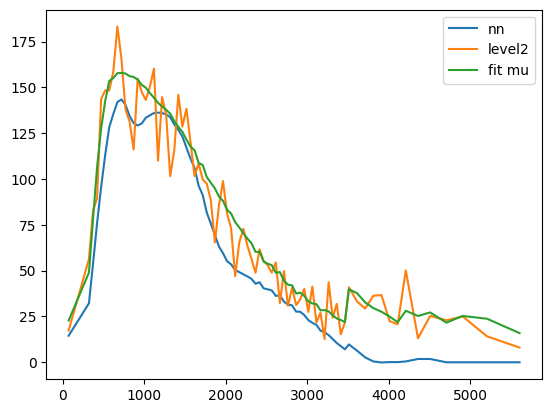

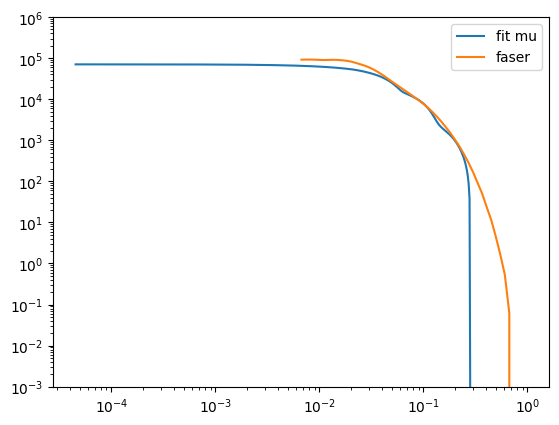

counter = 1058


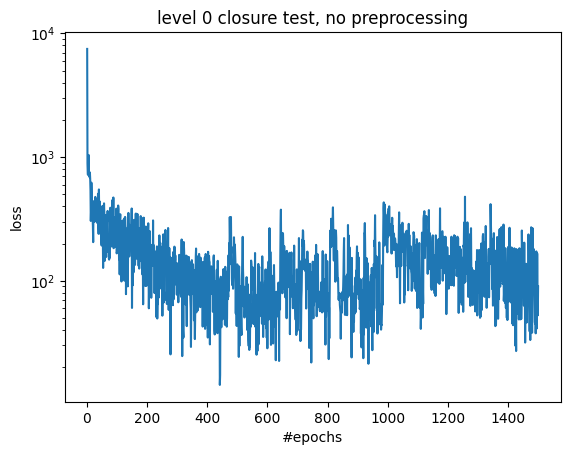

tensor([[69767.4609]], grad_fn=<SoftplusBackward0>)
tensor([[69767.4609]], grad_fn=<SoftplusBackward0>)
tensor(154.2084, grad_fn=<AddBackward0>)
tensor(454.9540, grad_fn=<AddBackward0>)
tensor(26.5060, grad_fn=<AddBackward0>)
tensor(109.9202, grad_fn=<AddBackward0>)
tensor(149.1569, grad_fn=<AddBackward0>)
tensor(219.6201, grad_fn=<AddBackward0>)
tensor(163.8672, grad_fn=<AddBackward0>)
tensor(293.1899, grad_fn=<AddBackward0>)
tensor(256.8279, grad_fn=<AddBackward0>)
tensor(100.2810, grad_fn=<AddBackward0>)
tensor(162.1874, grad_fn=<AddBackward0>)
tensor(226.1201, grad_fn=<AddBackward0>)
tensor(115.0450, grad_fn=<AddBackward0>)
tensor(176.4761, grad_fn=<AddBackward0>)
tensor(134.3904, grad_fn=<AddBackward0>)
tensor(110.9142, grad_fn=<AddBackward0>)
tensor(99.9848, grad_fn=<AddBackward0>)
tensor(135.1727, grad_fn=<AddBackward0>)
tensor(48.4711, grad_fn=<AddBackward0>)
tensor(106.9774, grad_fn=<AddBackward0>)
tensor(123.2361, grad_fn=<AddBackward0>)
tensor(101.0315, grad_fn=<AddBackward0

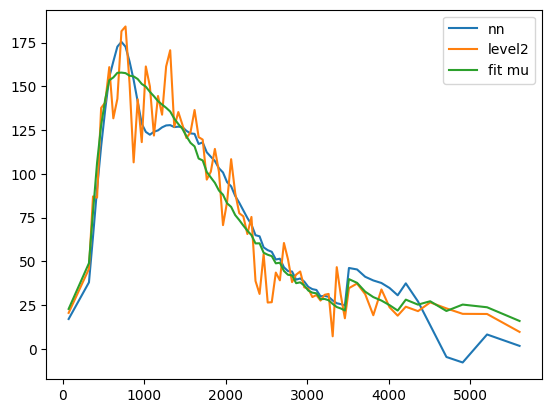

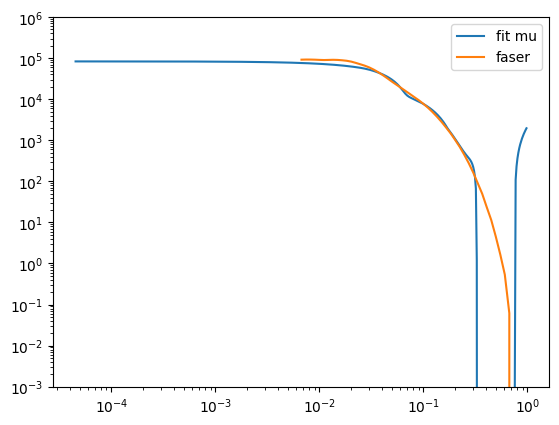

counter = 1269


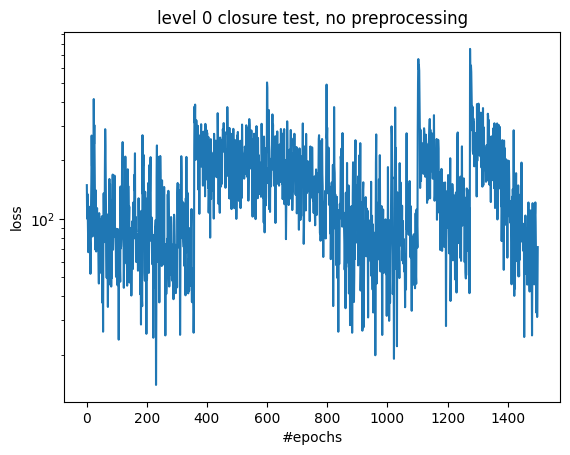

tensor([[82632.0312]], grad_fn=<SoftplusBackward0>)
tensor([[82632.0312]], grad_fn=<SoftplusBackward0>)
tensor(43.3309, grad_fn=<AddBackward0>)
tensor(47.8879, grad_fn=<AddBackward0>)
tensor(140.0048, grad_fn=<AddBackward0>)
tensor(43.4735, grad_fn=<AddBackward0>)
tensor(85.6282, grad_fn=<AddBackward0>)
tensor(126.1877, grad_fn=<AddBackward0>)
tensor(191.3733, grad_fn=<AddBackward0>)
tensor(70.6918, grad_fn=<AddBackward0>)
tensor(32.8786, grad_fn=<AddBackward0>)
tensor(127.3138, grad_fn=<AddBackward0>)
tensor(57.7616, grad_fn=<AddBackward0>)
tensor(71.9810, grad_fn=<AddBackward0>)
tensor(85.6801, grad_fn=<AddBackward0>)
tensor(39.6535, grad_fn=<AddBackward0>)
tensor(77.3560, grad_fn=<AddBackward0>)
tensor(74.2892, grad_fn=<AddBackward0>)
tensor(82.1401, grad_fn=<AddBackward0>)
tensor(63.2461, grad_fn=<AddBackward0>)
tensor(82.6341, grad_fn=<AddBackward0>)
tensor(141.6059, grad_fn=<AddBackward0>)
tensor(35.0519, grad_fn=<AddBackward0>)
tensor(21.3579, grad_fn=<AddBackward0>)
tensor(99.3

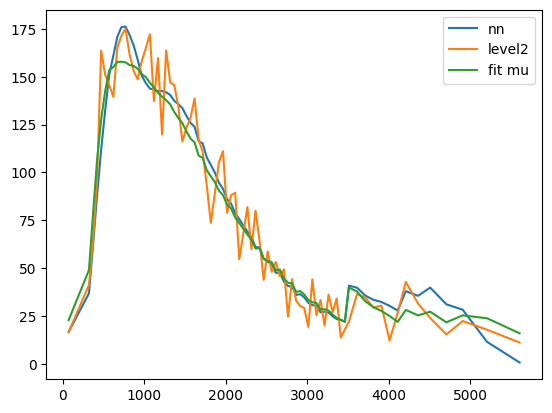

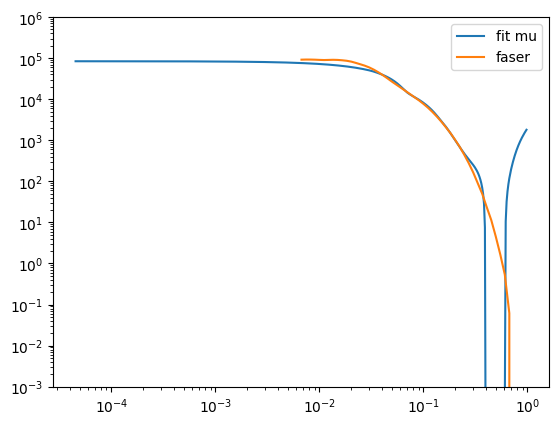

counter = 363


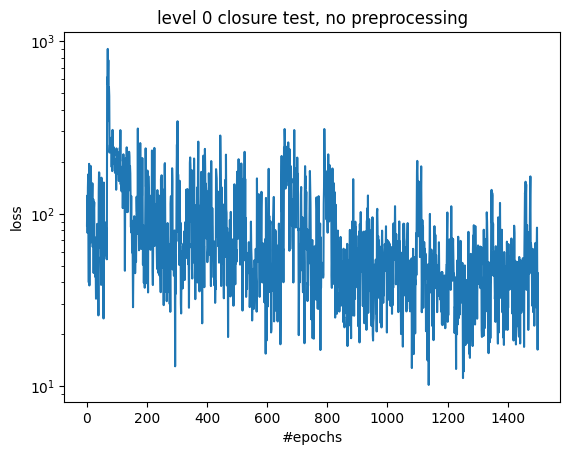

tensor([[83363.5156]], grad_fn=<SoftplusBackward0>)
tensor([[83363.5156]], grad_fn=<SoftplusBackward0>)
tensor(145.1819, grad_fn=<AddBackward0>)
tensor(56.5770, grad_fn=<AddBackward0>)
tensor(82.1003, grad_fn=<AddBackward0>)
tensor(27.7168, grad_fn=<AddBackward0>)
tensor(90.2032, grad_fn=<AddBackward0>)
tensor(63.2240, grad_fn=<AddBackward0>)
tensor(114.9811, grad_fn=<AddBackward0>)
tensor(54.2576, grad_fn=<AddBackward0>)
tensor(38.2865, grad_fn=<AddBackward0>)
tensor(64.0976, grad_fn=<AddBackward0>)
tensor(85.9690, grad_fn=<AddBackward0>)
tensor(80.8952, grad_fn=<AddBackward0>)
tensor(251.2701, grad_fn=<AddBackward0>)
tensor(49.1968, grad_fn=<AddBackward0>)
tensor(167.1974, grad_fn=<AddBackward0>)
tensor(41.8628, grad_fn=<AddBackward0>)
tensor(44.0927, grad_fn=<AddBackward0>)
tensor(85.3384, grad_fn=<AddBackward0>)
tensor(87.5713, grad_fn=<AddBackward0>)
tensor(50.7396, grad_fn=<AddBackward0>)
tensor(60.8772, grad_fn=<AddBackward0>)
tensor(153.0269, grad_fn=<AddBackward0>)
tensor(136.

KeyboardInterrupt: 

In [18]:
chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model = perform_fit(pred,REPLICAS)

In [ ]:
closure_fit = Postfit()
# neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(chi_squares,N_event_pred,neutrino_pdfs)

In [ ]:
x_vals = x_vals.detach().numpy().flatten()
pdf = "faserv"
print(pdf)
faser_pdf_mu,x_faser = read_pdf(pdf,x_vals,14) 
faser_pdf_mub,x_faser = read_pdf(pdf,x_vals,-14)
# mean_fnu = np.mean(neutrino_pdfs,axis=0) *x_vals
mean_fnu_mu = np.mean(neutrino_pdfs_mu,axis=0) 
mean_fnu_mub = np.mean(neutrino_pdfs_mub,axis=0) 

mean_pdf_preproc = np.mean(preproc_pdfs,axis=0) 
mean_nn_pdf = np.mean(nn_pdfs,axis=0) 

faserv
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# from lhapdf_grid import write_lhapdf_grid
# mean_fnu = np.mean(neutrino_pdfs, axis=0) * x_vals
# lhapdfpath = '/opt/anaconda3/envs/nnpdf_dev/share/LHAPDF/enu/enu_0000.dat'

# write_lhapdf_grid(x_vals,mean_fnu,lhapdfpath)

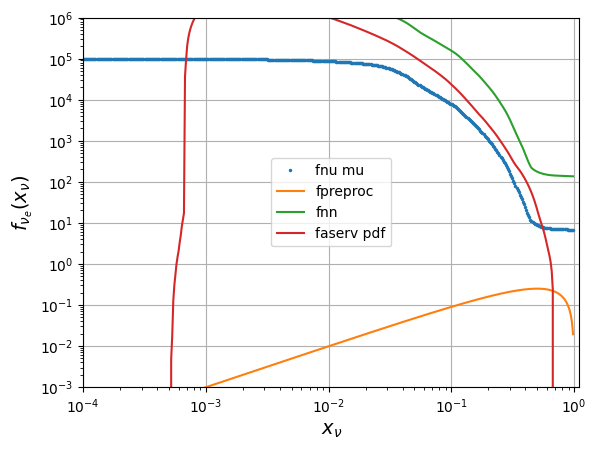

In [ ]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
# lowx = -8
# n=250
# x_vals = generate_grid(lowx,n)

x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
plt.plot(x_vals,mean_fnu_mu,'o',label="fnu mu",markersize=1.5)
plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5)
plt.plot(x_vals,mean_nn_pdf * 20,label="fnn",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf_mu * 3000/150,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
plt.ylim(10**-3,10**6)
plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (500, 1) and (1,)

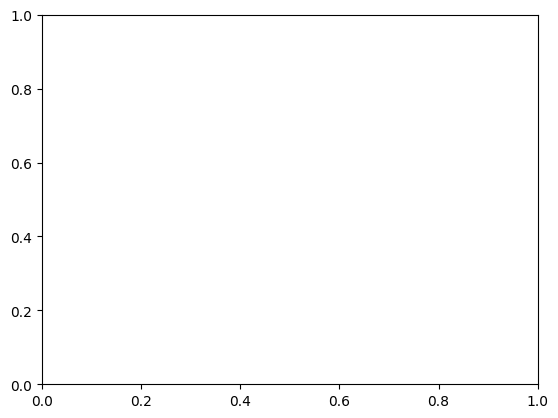

In [ ]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
plt.plot(x_vals,mean_fnu_mub,'o',label="fnu mub",markersize=1.5)
# plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5)
# plt.plot(x_vals,mean_nn_pdf,label="fnn",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf_mub,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
# plt.ylim(10**-3,10**6)
# plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
[ 20.952536  50.22644   78.736    104.757355 128.12991  141.54918
 151.45508  157.85545  155.01959  156.1598   156.48732  156.65033
 149.73665  151.90657  147.14964  148.5465   144.23503  144.98558
 142.05174  134.5747   135.50026  137.61223  131.98729  125.08464
 125.74958  122.156784 116.84743  111.20831  107.25057  101.13658
 103.32271  100.23214   93.97563   91.82909   89.652824  81.21713
  80.93012   74.722725  69.93095   71.531975  66.79499   59.045597
  62.097984  56.680252  55.415688  52.50674   52.244167  49.628696
  44.73354   46.135986  42.72786   40.79163   36.38572   36.493103
  33.90892   35.45101   29.543385  30.936169  31.197882  27.622189
  25.598967  24.856304  24.578941  23.113161  20.9

/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_72022/2412636520.py:1

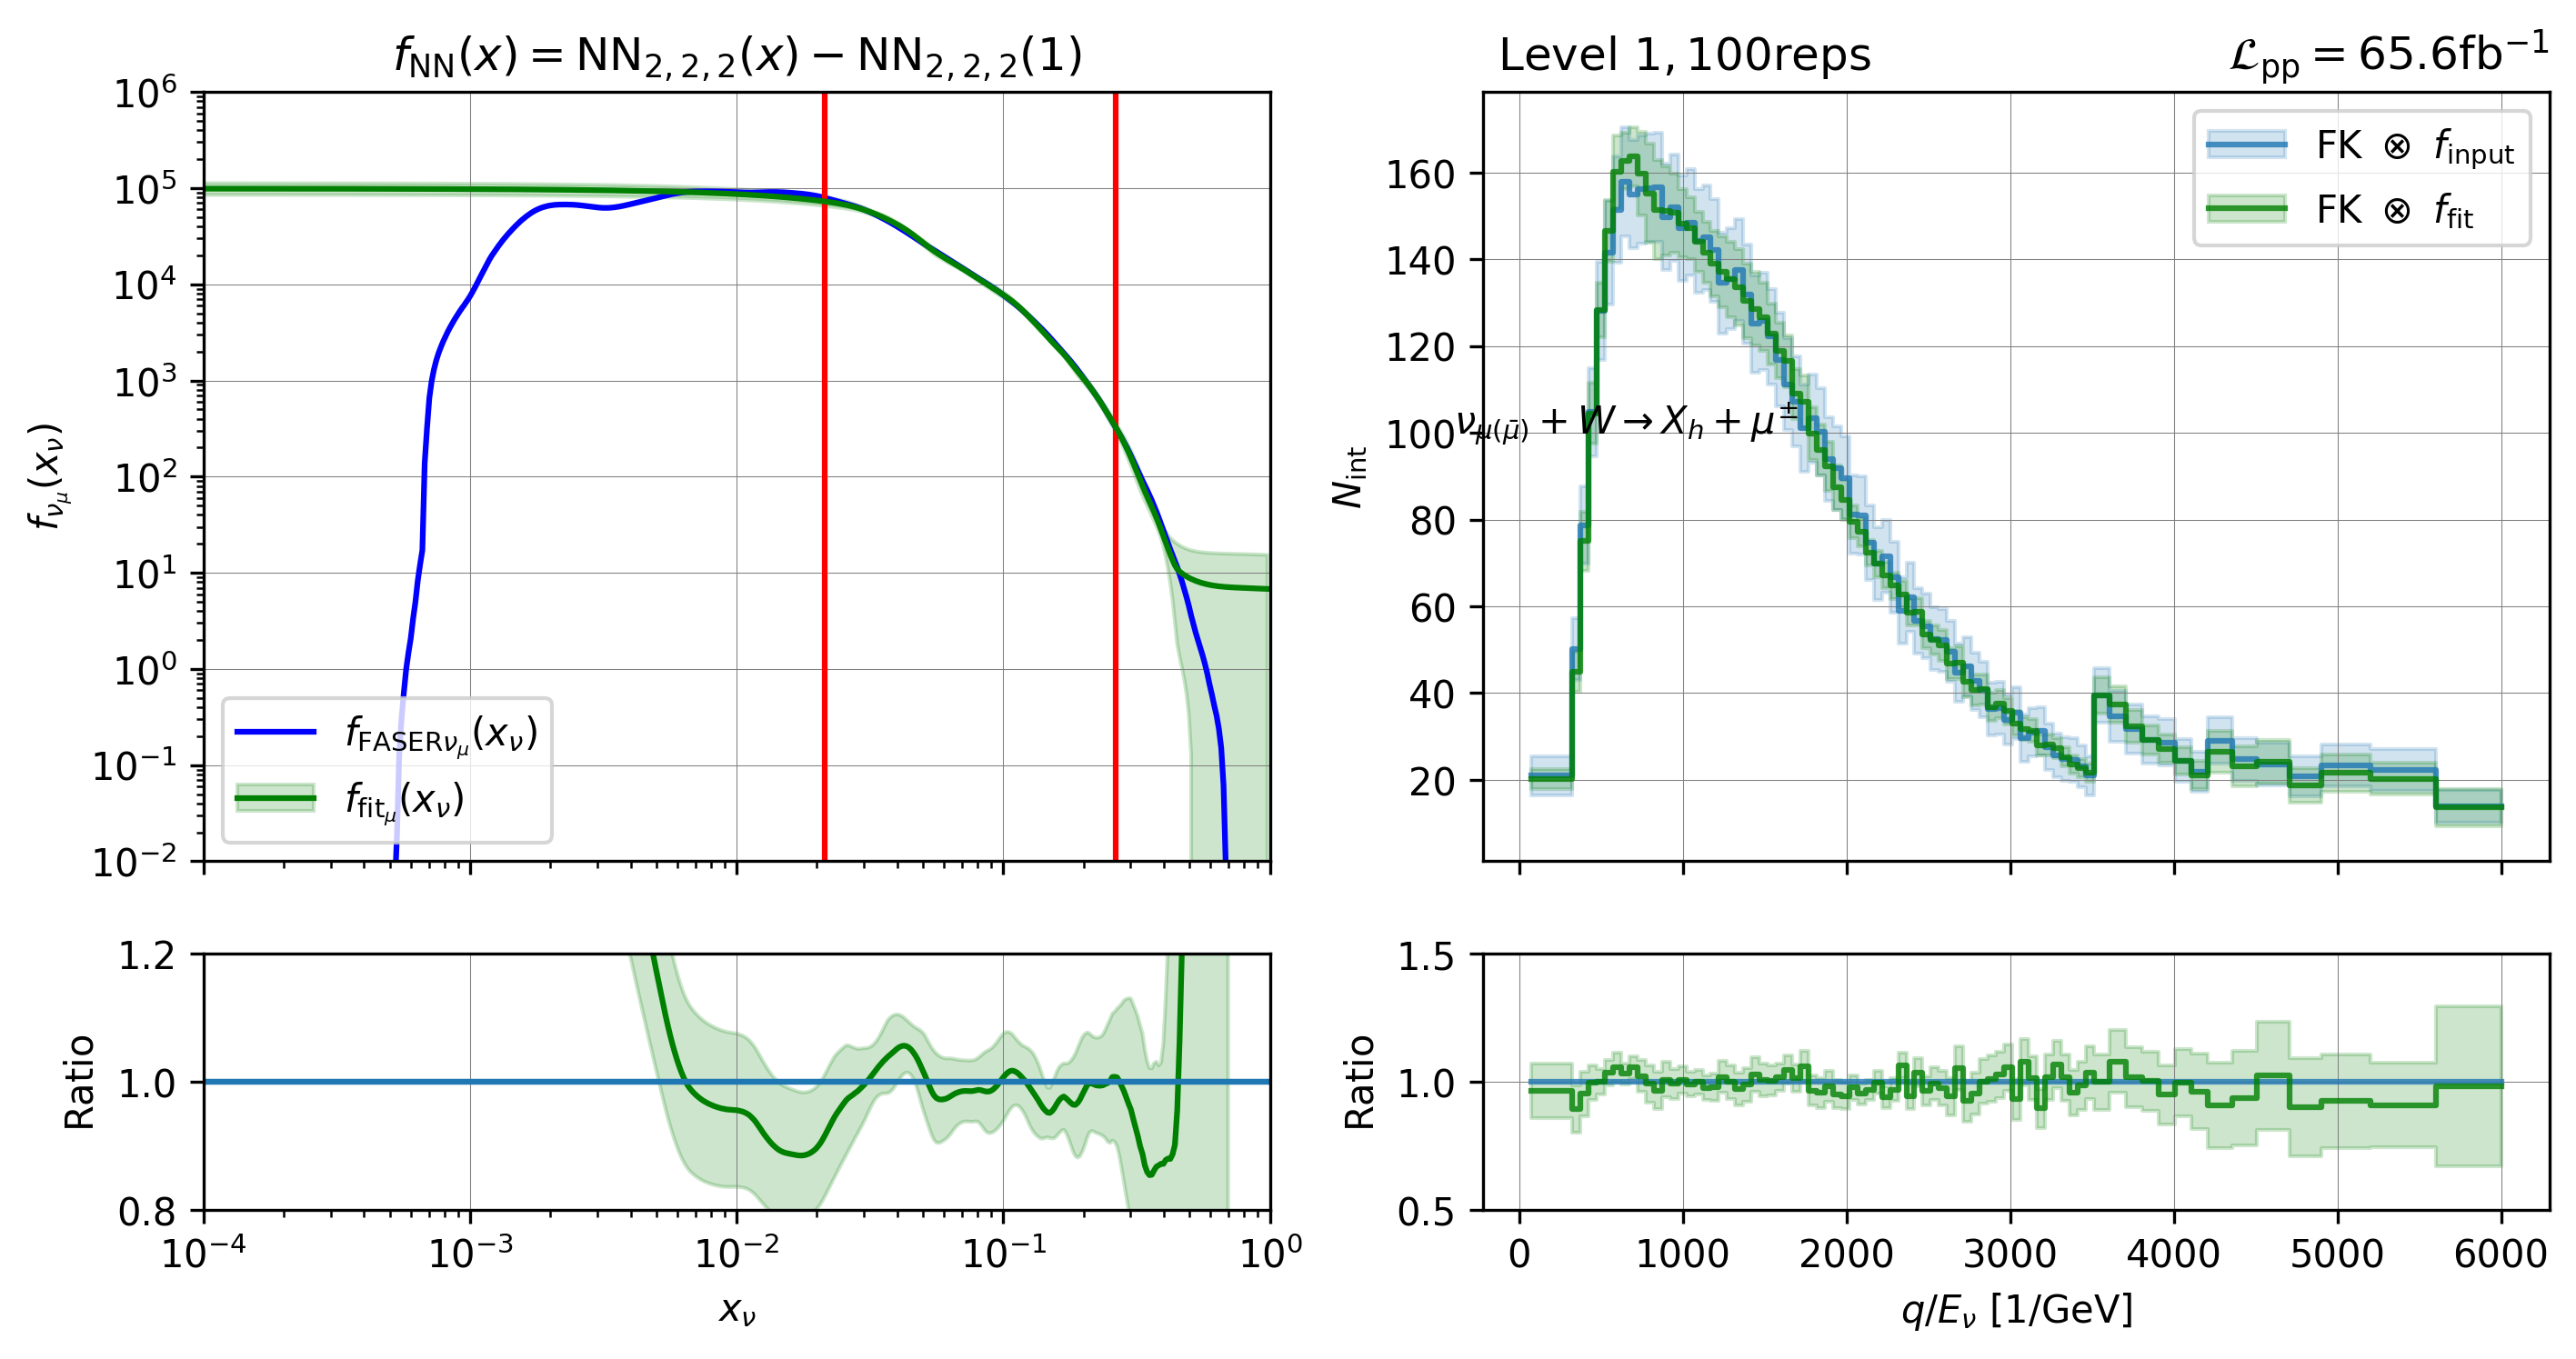

In [ ]:
from matplotlib.legend_handler import HandlerTuple
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from read_faserv_pdf import read_pdf

# Data for plot
import matplotlib.ticker as ticker


def plot_seperate(
    x_vals,
    neutrino_pdfs_mu,
    neutrino_pdfs_mub,
    level0,
    N_event_pred,
    sig_tot,
    xvals_per_obs,
    pid,
):
    pdf = "faserv"
    # pdf = "faserv"
    faser_pdf_mu, x_faser = read_pdf(pdf, x_vals, 12)
    faser_pdf_mub, x_faser = read_pdf(pdf, x_vals, -12)
    faser_pdf_mu = faser_pdf_mu * 3000/150
    faser_pdf_mub = faser_pdf_mub * 3000/150
    mean_fnu_mu = np.mean(neutrino_pdfs_mu, axis=0)
    error_fnu_mu = np.std(neutrino_pdfs_mu, axis=0)

    mean_fnu_mub = np.mean(neutrino_pdfs_mub, axis=0)
    error_fnu_mub = np.std(neutrino_pdfs_mub, axis=0)

    simulated_Enu = level0[0]
    preds_Enu = np.mean(N_event_pred, axis=0)
    pred_stds_Enu = np.std(N_event_pred, axis=0)
    # errors_enu = [5186, 6239, 4165, 1738, 622, 847]
    # errors_enu = np.array(errors_enu)
    # errors_enu = np.sqrt(level0[0])
    errors_enu = sig_tot

    xvals_per_obs = np.append(xvals_per_obs, 6000)
    simulated_Enu = np.append(simulated_Enu, simulated_Enu[-1])
    print(simulated_Enu)
    preds_Enu = np.append(preds_Enu, preds_Enu[-1])
    print(preds_Enu)
    pred_stds_Enu = np.append(pred_stds_Enu, pred_stds_Enu[-1])
    errors_enu = np.append(errors_enu, errors_enu[-1])
    # fig = plt.figure(figsize=(6.8, 3.4), dpi=300)  # 2 rows, 2 columns
    fig = plt.figure(figsize=(10, 5), dpi=300)
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])
    gs.update(left=0.09, right=0.95, top=0.93, hspace=0.18)

    axL = fig.add_subplot(gs[0, 0])
    axR = fig.add_subplot(gs[0, 1])
    axrL = fig.add_subplot(gs[1, 0])
    axrR = fig.add_subplot(gs[1, 1])

    # ======== TOP LEFT (Main plot, f_NN vs f_FASERv ) =============
    (axLsim_mu,) = axL.plot(
        x_vals,
        faser_pdf_mu,
        linestyle="-",
        color="b",
        label=r"$f_{\mathrm{FASER}\nu_\mu}(x_\nu)$",
    )

    # (axLsim_mub,) = axL.plot(
    #     x_vals,
    #     faser_pdf_mub,
    #     linestyle="--",
    #     color="b",
    #     label=r"$f_{\mathrm{FASER}\nu_{\bar{\mu}}}(x_\nu)$",
    # )

    axLvert1 = axL.axvline(x=150 / 7000, color="red", label="axvline - full height")
    axLvert2 = axL.axvline(x=1850 / 7000, color="red", label="axvline - full height")
    axLnnerr_mu = axL.fill_between(
        x_vals,
        (mean_fnu_mu + error_fnu_mu),
        (mean_fnu_mu - error_fnu_mu),
        color="green",
        alpha=0.2,
        label=r"$\pm 1\sigma$",
    )

    # axLnnerr_mub = axL.fill_between(
    #     x_vals,
    #     (mean_fnu_mub + error_fnu_mub),
    #     (mean_fnu_mub - error_fnu_mub),
    #     color="green",
    #     alpha=0.2,
    #     label=r"$\pm 1\sigma$",
    # )

    (axLnn_mu,) = axL.plot(
        x_vals,
        mean_fnu_mu,
        linestyle="-",
        color="green",
        label=r"$f_{\mathrm{fit}\mu}(x)$",
    )

    # (axLnn_mub,) = axL.plot(
    #     x_vals,
    #     mean_fnu_mub,
    #     linestyle="--",
    #     color="green",
    #     label=r"$f_{\mathrm{fit}\bar{\mu}}(x)$",
    # )

    axL.set_xlim(1e-4, 1)
    axL.set_ylim(1e-2, 1e6)
    axL.set_yscale("log")
    axL.set_xscale("log")
    axL.set_title(
        # r"$f_{\mathrm{NN}}(x) = \mathcal{A} \ x^{1-\alpha}(1-x)^\beta \ \mathrm{NN}(x)$"
        r"$f_{\mathrm{NN}}(x) = \mathrm{NN_{2,2,2}}(x) -\mathrm{NN_{2,2,2}}(1)$"
    )
    axL.set_ylabel(r"$f_{\nu_\mu}(x_\nu)$")
    axL.set_xticklabels([])
    axL.grid(color="grey", linestyle="-", linewidth=0.25)
    axL.yaxis.set_minor_locator(
        ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10)
    )
    axL.legend(
        [
            (axLsim_mu),
            # (axLsim_mub),
            # (axLvert1, axLvert2),
            # (axLsim_mub),
            (axLnn_mu, axLnnerr_mu),
            # (axLnn_mub, axLnnerr_mub),
        ],
        [
            r"$f_{\mathrm{FASER}\nu_\mu}(x_\nu)$",
            # r"$\mathrm{Data}\quad\mathrm{region}$",
            # r"$f_{\mathrm{FASER}\nu_{\bar{\mu}}}(x_\nu)$",
            r"$f_{\mathrm{fit}_\mu}(x_\nu)$",
            # r"$f_{\mathrm{fit}_{\bar{\mu}}}(x_\nu)$",
        ],
        handler_map={tuple: HandlerTuple(ndivide=1)},
        loc="lower left",
    ).set_alpha(0.8)

    # ========== BOTTOM LEFT (Ratio plot, f_NN vs f_FASERv )

    ratio_center = mean_fnu_mu / faser_pdf_mu
    ratio_lower = (mean_fnu_mu - error_fnu_mu) / faser_pdf_mu
    ratio_upper = (mean_fnu_mu + error_fnu_mu) / faser_pdf_mu

    axrL.plot(x_vals, ratio_center, linestyle="-", color="green")
    axrL.fill_between(x_vals, ratio_upper, ratio_lower, color="green", alpha=0.2)
    axrL.plot(x_vals, np.ones(len(x_vals)), linestyle="-", color="tab:blue")

    ratio_center = mean_fnu_mub / faser_pdf_mub
    ratio_lower = (mean_fnu_mub - error_fnu_mub) / faser_pdf_mub
    ratio_upper = (mean_fnu_mub + error_fnu_mub) / faser_pdf_mub

    axrL.plot(x_vals, ratio_center, linestyle="--", color="green")
    axrL.fill_between(x_vals, ratio_upper, ratio_lower, color="green", alpha=0.2)
    axrL.plot(x_vals, np.ones(len(x_vals)), linestyle="-", color="tab:blue")

    # axrL.axvline(x=200 / 7000, color="red", label="axvline - full height")
    # axrL.axvline(x=1450 / 7000, color="red", label="axvline - full height")

    axrL.set_xscale("log")
    axrL.set_xlim(1e-4, 1)
    axrL.set_ylim(0.8, 1.2)
    axrL.grid(color="grey", linestyle="-", linewidth=0.25)
    axrL.set_ylabel(r"$\mathrm{Ratio}$")
    axrL.set_xlabel(r"$x_\nu$")

    # =========== TOP RIGHT (Rates Enu vs FK otimes f_NN)

    # xvals_per_obs = [-1500, -1100, -600, 0.0, 1200, 1900, 2300]

    # xplot_Enumu = 1 / xplot_Enumu
    # xplot_Enumu[-1] = -1 / 1000
    # xplot_ticks = np.array(
    #     [-1 / 100, -1 / 300, -1 / 600, -1 / 1000, 1 / 1000, 1 / 300, 1 / 100]
    # )
    # ticks = np.linspace(0, 1, len(xplot_ticks))
    # xplot_Enumu = np.interp(-xplot_Enumu, xplot_ticks, ticks)
    # xplot_Enumub = 1 / xplot_Enumub
    # xplot_Enumub[-1] = -1 / 1000
    # xplot_Enumub = np.interp(xplot_Enumub, xplot_ticks, ticks)

    # sorted_indices = np.argsort(xvals_per_obs)
    # xvals_per_obs = xvals_per_obs[sorted_indices]
    # simulated_Enu = simulated_Enu[sorted_indices]
    # errors_enu = errors_enu[sorted_indices]
    # preds_Enu = preds_Enu[sorted_indices]
    # pred_stds_Enu = pred_stds_Enu[sorted_indices]

    (axRsim,) = axR.plot(
        xvals_per_obs,
        simulated_Enu,
        drawstyle="steps-post",
        color="tab:blue",
        alpha=0.8,
    )
    axRsimerr = axR.fill_between(
        xvals_per_obs,
        simulated_Enu + errors_enu,
        simulated_Enu - errors_enu,
        step="post",
        color="tab:blue",
        alpha=0.2,
        label=r"POWHEG $E_\nu$",
    )

    (axRpred,) = axR.plot(
        xvals_per_obs,
        preds_Enu,
        color="green",
        drawstyle="steps-post",
        alpha=0.8,
        label=r"$\mathrm{NN}(E_\nu)$",
    )
    axRprederr = axR.fill_between(
        xvals_per_obs,
        (preds_Enu + pred_stds_Enu),
        (preds_Enu - pred_stds_Enu),
        color="green",
        alpha=0.2,
        step="post",
        label=r"$\pm 1\sigma$",
    )
    axR.legend(
        [(axRsimerr, axRsim), (axRprederr, axRpred)],
        [
            r"$\mathrm{FK} \ \otimes \ f_{\mathrm{input}}$",
            r"$\mathrm{FK} \ \otimes \ f_{\mathrm{fit}}$",
        ],
        handler_map={tuple: HandlerTuple(ndivide=1)},
        loc="upper right",
    ).set_alpha(0.8)
    # axR.set_xlim(0)
    # axR.set_ylim(0)
    # tick_labels = [
    #     r"$-\frac{1}{100}$",
    #     r"$-\frac{1}{300}$",
    #     r"$-\frac{1}{600}$",
    #     r"$-\frac{1}{1000}$",
    #     r"$\frac{1}{1000}$",
    #     r"$\frac{1}{300}$",
    #     r"$\frac{1}{100}$",
    # ]

    # # Use `xvals_per_obs` positions for labels
    # axR.set_xticks(xvals_per_obs)
    # axR.set_xticklabels(tick_labels)

    axR.grid(color="grey", linestyle="-", linewidth=0.25)
    axR.set_xticklabels([])
    axR.set_title(r"$\mathcal{L}_{\mathrm{pp}} = 65.6 \mathrm{fb}^{-1}$", loc="right")
    axR.set_title(r"$\ \mathrm{Level\ 1},100 \mathrm{reps}$", loc="left")
    axR.text(-400, 100, r"$\nu_{\mu(\bar{\mu})} + W \rightarrow X_h+  \mu^{\pm} $")
    axR.set_ylabel(r"$N_{\mathrm{int}}$")

    ratio_center_pred = preds_Enu / simulated_Enu
    ratio_lower_pred = (preds_Enu - pred_stds_Enu) / simulated_Enu
    ratio_upper_pred = (preds_Enu + pred_stds_Enu) / simulated_Enu
    ratio_upper_sim = (simulated_Enu + errors_enu) / simulated_Enu
    ratio_lower_sim = (simulated_Enu + errors_enu) / simulated_Enu

    axrR.fill_between(
        xvals_per_obs, ratio_upper_sim, ratio_lower_sim, step="post", alpha=0.2
    )
    axrR.plot(
        xvals_per_obs, np.ones(len(simulated_Enu)), drawstyle="steps-post", alpha=0.8
    )

    axrR.fill_between(
        xvals_per_obs,
        ratio_upper_pred,
        ratio_lower_pred,
        step="post",
        alpha=0.2,
        color="green",
    )
    axrR.plot(
        xvals_per_obs,
        ratio_center_pred,
        drawstyle="steps-post",
        alpha=0.8,
        color="green",
    )

    axrR.set_ylabel(r"$\mathrm{Ratio}$")
    axrR.set_xlabel(r"$q/E_\nu \ [\mathrm{1/GeV}]$")
    axrR.set_ylim(0.5, 1.5)
    # axrR.set_xlim(0)
    axrR.grid(color="grey", linestyle="-", linewidth=0.25)

    # tick_labels = [
    #     r"$-\frac{1}{100}$",
    #     r"$-\frac{1}{300}$",
    #     r"$-\frac{1}{600}$",
    #     r"$-\frac{1}{1000}$",
    #     r"$\frac{1}{1000}$",
    #     r"$\frac{1}{300}$",
    #     r"$\frac{1}{100}$",
    # ]

    # # Use `xvals_per_obs` positions for labels
    # axrR.set_xticks(xvals_per_obs)
    # axrR.set_xticklabels(tick_labels)

    axrR.set_xlabel(r"$q/E_\nu \ [\mathrm{1/GeV}]$")

    plt.savefig("fasersimdata.pdf")

sig_tot = 1/np.sqrt(np.diag(cov_matrix)) 
# x_vals = x_vals.detach().numpy().flatten()
plot_seperate(x_vals, neutrino_pdfs_mu, neutrino_pdfs_mub,level0, N_event_pred, sig_tot, xvals_per_obs,14)

In [ ]:
from plot_results_faser_sim import plot
sig_tot = sig_sys+sig_stat
print(sig_tot)
plot(x_vals, neutrino_pdfs_mu, level0, N_event_pred, sig_tot, xvals_per_obs,14)
plot(x_vals, neutrino_pdfs_mub, level0, N_event_pred, sig_tot, xvals_per_obs,-14)

[12.763324 15.227586 13.86459  19.479156 10.222648  6.13222 ]


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

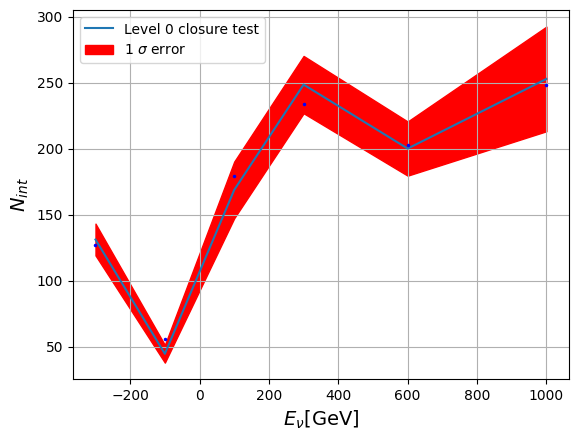

In [ ]:

mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
xvals_per_obs = np.array(xvals_per_obs)
sorted_indices = np.argsort(xvals_per_obs)

# Sort both arrays using the same indices
sorted_xvals_per_obs = xvals_per_obs[sorted_indices]
sorted_mean_N_event_fit = mean_N_event_fit[sorted_indices]
sorted_sigma_N_event_fit = sigma_N_event_fit[sorted_indices]
level0data = level0[0]
sorted_level0 = level0data[sorted_indices]

plt.plot(sorted_xvals_per_obs,sorted_mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(sorted_xvals_per_obs,(sorted_mean_N_event_fit+sorted_sigma_N_event_fit),(sorted_mean_N_event_fit-sorted_sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(sorted_xvals_per_obs,sorted_level0,'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

In [ ]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
# x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

TypeError: read_pdf() missing 1 required positional argument: 'particle'

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [ ]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo